In [14]:
!pip install pretrainedmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=fb4bf65ff07ead405c9c81f4c4e1670e095b328a4e42ef373b9056c490ac0305
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built pretrainedmodels


Import the required libraries

In [15]:
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from PIL import Image
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
import pretrainedmodels

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Extract the data from .tar file to a new folder

In [7]:
import tarfile
my_tar = tarfile.open("drive/MyDrive/Copy of train_and_val_set.tar")
my_tar.extractall("CVA2")
my_tar.close()

Data Loading & Pre-Processing

In [8]:
class FaceDataset(Dataset):
    def __init__(self, train_path, transform=None):
        self.images_path = os.path.join(train_path, 'images')
        self.annotations_path = os.path.join(train_path, 'annotations')
        self.transform = transform
        self.image_files = sorted(os.listdir(self.images_path))
        self.annotation_files = sorted(os.listdir(self.annotations_path))
    def __len__(self):
        return len(self.image_files)
    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.images_path, self.image_files[idx])).convert("RGB")
        if self.transform:
            image = self.transform(image)
       
        annotation_path = os.path.join(self.annotations_path, self.image_files[idx] ).replace(".jpg", "_exp.npy")
  
        landmarks = np.load(annotation_path.replace("_exp.npy", "_lnd.npy"))
   
        landmarks = torch.tensor(landmarks, dtype=torch.float32)
        
        arousal = float(np.load(annotation_path.replace("_exp.npy", "_aro.npy")))
        valence = float(np.load(annotation_path.replace("_exp.npy", "_val.npy")))
        
        
        arousal_valence = torch.tensor([arousal, valence], dtype=torch.float32)

        expression = float(np.load(annotation_path))
        expression = torch.tensor(expression, dtype=torch.long)
        
        return image, landmarks, arousal_valence, expression

In [30]:
class ModelComparison(nn.Module):
    def __init__(self, model_name='resnet18'):
        super(ModelComparison, self).__init__()
        if model_name == 'resnet18':
            self.resnet = models.resnet18(pretrained=True)
            num_ftrs = self.resnet.fc.in_features
            self.resnet.fc = nn.Linear(num_ftrs, 512)
            for param in self.resnet.parameters():
                param.requires_grad = False
        elif model_name == 'densenet121':
            self.resnet = models.densenet121(pretrained=True)
            num_ftrs = self.resnet.classifier.in_features
            self.resnet.classifier = nn.Linear(num_ftrs, 512)
            for param in self.resnet.parameters():
                param.requires_grad = False
        elif model_name == 'xception':
            self.resnet = pretrainedmodels.__dict__['xception'](pretrained='imagenet')
            #self.resnet = models.xception(pretrained=True)
            num_ftrs = self.resnet.fc.in_features
            self.resnet.fc = nn.Linear(num_ftrs, 512)
            for param in self.resnet.parameters():
                param.requires_grad = False
        else:
            raise ValueError("Invalid model_name")
        self.arousal_valence_head = nn.Linear(512, 2)
        self.expression_head = nn.Linear(512, 8)

    def forward(self, x):
        x = self.resnet(x)           
        arousal_valence = self.arousal_valence_head(x)
        expression = self.expression_head(x)
        return arousal_valence, expression



Accuracy Function

In [10]:
def calculate_accuracy(loader, model, device):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, landmarks, arousal_valence_labels, expression_labels in loader:
            images = images.to(device)
            
            expression_labels = expression_labels.to(device)

            _, expression_preds = model(images)  # Pass the landmarks tensor here
            _, predicted = torch.max(expression_preds.data, 1)
            total += expression_labels.size(0)
            correct += (predicted == expression_labels).sum().item()

    return 100 * correct / total


Data Prep

In [11]:
# Dataset preparation and pre-processing
# Add data augmentation
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomGrayscale(p=0.1),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = FaceDataset("CVA2/train_set/", transform_train)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Training DenseNet

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ModelComparison(model_name="densenet121").to(device)
#model2 = ModelComparison(model_name="resnet18").to(device)
#model3 = ModelComparison(model_name="xception").to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)



criterion1 = nn.MSELoss()
criterion2 = nn.CrossEntropyLoss()

In [31]:
num_epochs = 1
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    for i, (images, landmarks, arousal_valence_labels, expression_labels) in loop:
        
        images = images.to(device)
        #landmarks = landmarks.to(device)
        arousal_valence_labels = arousal_valence_labels.to(device)
        expression_labels = expression_labels.to(device)
        # rest of the code
        optimizer.zero_grad()
        arousal_valence_preds, expression_preds = model(images)
        loss1 = criterion1(arousal_valence_preds, arousal_valence_labels)
        loss2 = criterion2(expression_preds, expression_labels)
        loss = loss1 + loss2

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=running_loss / (i + 1))

    train_losses.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    running_val_loss = 0.0
    val_loop = tqdm(enumerate(val_loader), total=len(val_loader), leave=True)
    with torch.no_grad():
        for i, (images, landmarks, arousal_valence_labels, expression_labels) in val_loop:
            images = images.to(device)
            #landmarks = landmarks.to(device)
            arousal_valence_labels = arousal_valence_labels.to(device)
            expression_labels = expression_labels.to(device)

            arousal_valence_preds, expression_preds = model(images)
            val_loss1 = criterion1(arousal_valence_preds, arousal_valence_labels)
            val_loss2 = criterion2(expression_preds, expression_labels)
            val_loss = val_loss1 + val_loss2

            running_val_loss += val_loss.item()
            val_loop.set_description(f"Validation Epoch [{epoch+1}/{num_epochs}]")
            val_loop.set_postfix(val_loss=running_val_loss / (i + 1))

    val_losses.append(running_val_loss / len(val_loader))

    # Update the learning rate using the scheduler
    scheduler.step()

Validation Epoch [1/1]: 100%|██████████| 1798/1798 [17:49<00:00,  1.68it/s, val_loss=1.38]


In [32]:
model_path = "densenet.pth"
torch.save(model.state_dict(), model_path)
     

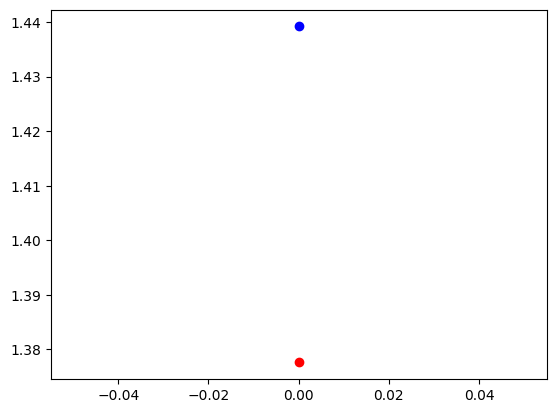

In [33]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='DenseNet Loss', linestyle='-', marker='o', color='blue')
plt.plot(val_losses, label='DenseNet Validation Loss', linestyle='-', marker='o', color='red')
plt.show()

In [35]:
import tarfile
my_tar = tarfile.open("drive/MyDrive/Copy of test_set.tar")
my_tar.extractall("test_set")
my_tar.close()
     


In [36]:
# Dataset preparation and pre-processing
# Add data augmentation
test_dataset = FaceDataset("test_set/val_set", transform_train)
test_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [37]:
def predict_image(image_path, model, device, transform):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)


    # Make the prediction
    model.eval()
    with torch.no_grad():
        arousal_valence_preds, expression_preds = model(image_tensor)

    arousal_valence = arousal_valence_preds.cpu().numpy()
    expression = torch.argmax(expression_preds, dim=1).cpu().numpy()

    return arousal_valence, expression

# Usage example
image_path = "test_set/val_set/images/184.jpg"
landmarks_path = "test_set/val_set/annotations/184_lnd.npy"
# model = model.to(device)
arousal_valence, emotions = predict_image(image_path, model, device, transform_train)
emotion_dict = {0: "Neutral", 1: "Happy", 2: "Sad", 3: "Surprise", 4:
"Fear", 5: "Disgust", 6: "Anger", 7: 'Contempt'}

print("Predicted_traits:")

print("emotion = ", emotion_dict[emotions.item()])
print("Arousal = ", arousal_valence[0][0])
print("Valence = ", arousal_valence[0][1])

Predicted_traits:
emotion =  Neutral
Arousal =  0.12124173
Valence =  0.09731329


In [39]:

model.eval()
# Usage example
image_path = "test_set/val_set/images/182.jpg"
arousal_valence, emotions = predict_image(image_path, model, device, transform_train)
emotion_dict = {0: "Neutral", 1: "Happy", 2: "Sad", 3: "Surprise", 4:
"Fear", 5: "Disgust", 6: "Anger", 7: 'Contempt'}

print("Predicted_traits:")

print("emotion = ", emotion_dict[emotions.item()])
print("Arousal = ", arousal_valence[0][0])
print("Valence = ", arousal_valence[0][1])

print("Real Emotion:", emotion_dict[int(np.load("test_set/val_set/annotations/184_exp.npy").item())])
print("Real Arousal:", np.load("test_set/val_set/annotations/184_aro.npy"))
print("Real Valence:", np.load("test_set/val_set/annotations/184_val.npy"))

Predicted_traits:
emotion =  Happy
Arousal =  0.164168
Valence =  0.03777817
Real Emotion: Neutral
Real Arousal: -0.200169
Real Valence: 0.200169


# Xception


In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model =  ModelComparison(model_name="resnet18").to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
criterion1 = nn.MSELoss()
criterion2 = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [42]:
num_epochs = 1
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    for i, (images, landmarks, arousal_valence_labels, expression_labels) in loop:
        
        images = images.to(device)
        #landmarks = landmarks.to(device)
        arousal_valence_labels = arousal_valence_labels.to(device)
        expression_labels = expression_labels.to(device)
        # rest of the code
        optimizer.zero_grad()
        arousal_valence_preds, expression_preds = model(images)
        loss1 = criterion1(arousal_valence_preds, arousal_valence_labels)
        loss2 = criterion2(expression_preds, expression_labels)
        loss = loss1 + loss2

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=running_loss / (i + 1))

    train_losses.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    running_val_loss = 0.0
    val_loop = tqdm(enumerate(val_loader), total=len(val_loader), leave=True)
    with torch.no_grad():
        for i, (images, landmarks, arousal_valence_labels, expression_labels) in val_loop:
            images = images.to(device)
            #landmarks = landmarks.to(device)
            arousal_valence_labels = arousal_valence_labels.to(device)
            expression_labels = expression_labels.to(device)

            arousal_valence_preds, expression_preds = model(images)
            val_loss1 = criterion1(arousal_valence_preds, arousal_valence_labels)
            val_loss2 = criterion2(expression_preds, expression_labels)
            val_loss = val_loss1 + val_loss2

            running_val_loss += val_loss.item()
            val_loop.set_description(f"Validation Epoch [{epoch+1}/{num_epochs}]")
            val_loop.set_postfix(val_loss=running_val_loss / (i + 1))

    val_losses.append(running_val_loss / len(val_loader))

    # Update the learning rate using the scheduler
    scheduler.step()

Validation Epoch [1/1]: 100%|██████████| 1798/1798 [16:06<00:00,  1.86it/s, val_loss=1.37]


In [43]:
model_path = "resnet.pth"
torch.save(model.state_dict(), model_path)
     

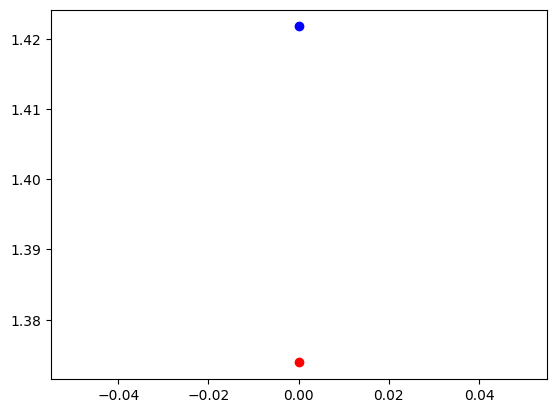

In [44]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='ResNet Loss', linestyle='-', marker='o', color='blue')
plt.plot(val_losses, label='ResNet Validation Loss', linestyle='-', marker='o', color='red')
plt.show()

# Testing

In [45]:

import tarfile
my_tar = tarfile.open("drive/MyDrive/Copy of test_set.tar")
my_tar.extractall("test_set")
my_tar.close()

In [46]:

# Dataset preparation and pre-processing
# Add data augmentation
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_dataset = FaceDataset("test_set/val_set", transform_train)





test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Create a new instance of the model
densenet_model = ModelComparison("densenet121")
resnet_model =ModelComparison("resnet18")

model_path_resenet = "/content/resnet.pth" # Change with your path to resnet_backend_model
model_path_densenet = "/content/densenet.pth"  # Change with your path to densenet_backend_model
# Load the saved state_dict
resnet_model.load_state_dict(torch.load(model_path_resenet, map_location=torch.device('cpu')))
densenet_model.load_state_dict(torch.load(model_path_densenet, map_location=torch.device('cpu')))

# Move the model to the desired device
resnet_model = resnet_model.to(device)
densenet_model = densenet_model.to(device)
# Set the model to evaluation mode if you're going to use it for inference
resnet_model.eval()
densenet_model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ModelComparison(
  (resnet): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momen

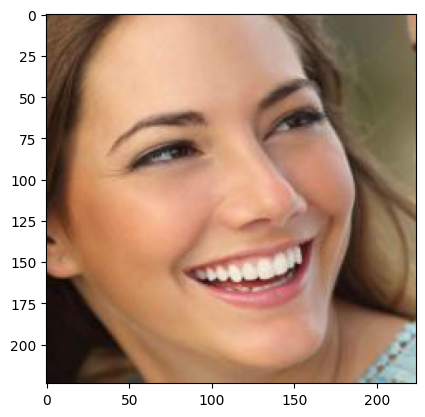

Predicted_traits:
emotion =  Happy
Arousal =  0.110882744
Valence =  0.3420839
Real Emotion: Happy
Real Arousal: 0.087108
Real Valence: 0.416183


In [51]:
import matplotlib.pyplot as plt

def predict_image(image_path, model, device, transform):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)


    # Make the prediction
    model.eval()
    with torch.no_grad():
        arousal_valence_preds, expression_preds = model(image_tensor)

    arousal_valence = arousal_valence_preds.cpu().numpy()
    expression = torch.argmax(expression_preds, dim=1).cpu().numpy()

    return arousal_valence, expression


image_number = "350"
# Usage example
image_path = f'test_set/val_set/images/{image_number}.jpg'
arousal_valence, emotions = predict_image(image_path, resnet_model, device, transform_train)
emotion_dict = {0: "Neutral", 1: "Happy", 2: "Sad", 3: "Surprise", 4:
"Fear", 5: "Disgust", 6: "Anger", 7: 'Contempt'}

plt.imshow(plt.imread(f'test_set/val_set/images/{image_number}.jpg'))
plt.show()

print("Predicted_traits:")

print("emotion = ", emotion_dict[emotions.item()])
print("Arousal = ", arousal_valence[0][0])
print("Valence = ", arousal_valence[0][1])

print("Real Emotion:", emotion_dict[int(np.load(f'test_set/val_set/annotations/{image_number}_exp.npy').item())])
print("Real Arousal:", np.load(f'test_set/val_set/annotations/{image_number}_aro.npy'))
print("Real Valence:", np.load(f'test_set/val_set/annotations/{image_number}_val.npy'))
     

Wrongly Classified

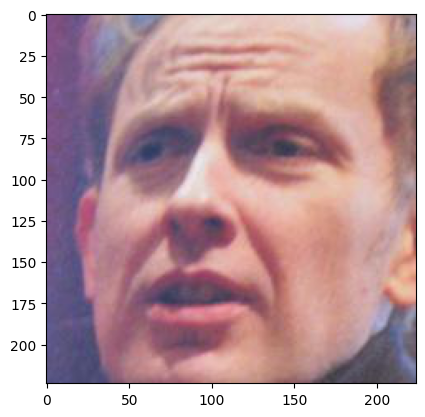

Predicted_traits:
emotion =  Happy
Arousal =  0.21556348
Valence =  0.033626955
Real Emotion: Disgust
Real Arousal: 0.454897
Real Valence: -0.759775


In [52]:
image_number = "300"
# Usage example
image_path = f'test_set/val_set/images/{image_number}.jpg'
arousal_valence, emotions = predict_image(image_path, resnet_model, device, transform_train)
emotion_dict = {0: "Neutral", 1: "Happy", 2: "Sad", 3: "Surprise", 4:
"Fear", 5: "Disgust", 6: "Anger", 7: 'Contempt'}

plt.imshow(plt.imread(f'test_set/val_set/images/{image_number}.jpg'))
plt.show()

print("Predicted_traits:")

print("emotion = ", emotion_dict[emotions.item()])
print("Arousal = ", arousal_valence[0][0])
print("Valence = ", arousal_valence[0][1])

print("Real Emotion:", emotion_dict[int(np.load(f'test_set/val_set/annotations/{image_number}_exp.npy').item())])
print("Real Arousal:", np.load(f'test_set/val_set/annotations/{image_number}_aro.npy'))
print("Real Valence:", np.load(f'test_set/val_set/annotations/{image_number}_val.npy'))

In [54]:
!pip install krippendorff

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [57]:
!pip install pyRSMetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement pyRSMetrics (from versions: none)
ERROR: No matching distribution found for pyRSMetrics


In [73]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, roc_auc_score, average_precision_score
from krippendorff import alpha as k_alpha
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from statsmodels.stats.contingency_tables import mcnemar
#from pyRSMetrics import ccc
def evaluate_model(model, loader, device):
    expression_preds = []
    expression_true = []
    arousal_valence_preds = []
    arousal_valence_true = []
    
    with torch.no_grad():
        for images, landmarks, arousal_valence_labels, expression_labels in loader:
            images = images.to(device)
            

            arousal_valence_pred, expression_pred = model(images)
            expression_pred = torch.argmax(expression_pred, dim=1)

            expression_preds.extend(expression_pred.cpu().numpy())
            expression_true.extend(expression_labels.cpu().numpy())
            arousal_valence_preds.extend(arousal_valence_pred.cpu().numpy())
            arousal_valence_true.extend(arousal_valence_labels.cpu().numpy())

    # Calculate metrics for expression classification
    accuracy = accuracy_score(expression_true, expression_preds)
    precision = precision_score(expression_true, expression_preds, average='weighted')
    recall = recall_score(expression_true, expression_preds, average='weighted')
    f1 = f1_score(expression_true, expression_preds, average='weighted')
    kappa = cohen_kappa_score(expression_true, expression_preds)
    # Calculate AUC
   # auc = roc_auc_score(expression_true.numpy().reshape(-1, 1), expression_preds.numpy().reshape(-1, 1),multi_class='ovr')
    # Calculate AUC-PR
    #auc_pr = average_precision_score(expression_true, expression_preds, multi_class='ovr')

    # Calculate Krippendorff's alpha
#    alpha = k_alpha(reliability_data=[expression_preds], value_counts=[2], level_of_measurement='nominal')

    # Calculate metrics for arousal and valence regression
    mse = mean_squared_error(arousal_valence_true, arousal_valence_preds)
    mae = mean_absolute_error(arousal_valence_true, arousal_valence_preds)
    # Calculate RMSE
    #r=torch.from_numpy(mse)
    #rmse = torch.sqrt(r)
    # Calculate concordance correlation coefficient
    #ccc_score = ccc( arousal_valence_preds.numpy(), arousal_valence_true.numpy())

    # Calculate correlation coefficient
   # corr_coeff, _ = pearsonr( arousal_valence_preds, arousal_valence_true)

    return accuracy, precision, recall, f1, kappa, mse, mae

# Load test dataset
test_dataset = FaceDataset("test_set/val_set/", transform=transform_train)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
# Evaluate ResNet model
resnet_metrics = evaluate_model(resnet_model, test_loader, device)

# Evaluate DenseNet model
densenet_metrics = evaluate_model(densenet_model, test_loader, device)

# Print metrics
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-score','Cohens Kappa','MSE', 'MAE']
print("ResNet Metrics:")
for name, value in zip(metric_names, resnet_metrics):
    print(f"{name}: {value}")
    
print("\nDenseNet Metrics:")
for name, value in zip(metric_names, densenet_metrics):
    print(f"{name}: {value}")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ResNet Metrics:
Accuracy: 0.21905476369092272
Precision: 0.302683253690795
Recall: 0.21905476369092272
F1-score: 0.1406336311473329
Cohens Kappa: 0.10745927407830813
MSE: 0.20277760922908783
MAE: 0.3785664439201355

DenseNet Metrics:
Accuracy: 0.1935483870967742
Precision: 0.1750293972899191
Recall: 0.1935483870967742
F1-score: 0.10408511335444122
Cohens Kappa: 0.07830808802514999
MSE: 0.2510943114757538
MAE: 0.41753900051116943


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [77]:
!pip install torchviz


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4147 sha256=3a43571c2f1e36eebcf479a1f8ce7dd98688b343dd11af1b4a18ecb64d12588f
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [80]:
from torchviz import make_dot
for images, landmarks, arousal_valence_labels, expression_labels in test_loader:

  # Load the trained model
  model = ModelComparison()
  model.load_state_dict(torch.load("/content/resnet.pth", map_location=torch.device('cpu')))
  # Run the model with the random inputs
  arousal_valence, expression = model(images)

  break
# Visualize the model
graph = make_dot(arousal_valence, params=dict(model.named_parameters()))
  # break
graph.format = 'png'
graph.render("model_graph_resnet")

'model_graph_resnet.png'

In [85]:
from torchviz import make_dot
for images, landmarks, arousal_valence_labels, expression_labels in test_loader:

  # Load the trained model
  model = ModelComparison()
  model.load_state_dict(torch.load("/content/densenet.pth", map_location=torch.device('cpu')))
  # Run the model with the random inputs
  arousal_valence, expression = model(images)

  break
# Visualize the model
graph = make_dot(arousal_valence, params=dict(model.named_parameters()))
  # break
graph.format = 'png'
graph.render("model_graph_dense")

RuntimeError: ignored